- Sentence Transformer for embedding abstracts
- Reducing embedding dimensionality with UMAP
- Apply HDBSCAN for density-based clustering without pre-defining number of clusters

Results:
- Large proportion of points classified as noise
- Many clusters are small and fragmented
- No clear high-level structure emerges across the full dataset
    - Indicates that HDBSCAN struggles to identify stable global topics
    - Suggests trying K-Means or other clustering approaches on the UMAP projection

In [1]:
import json
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns 
from sentence_transformers import SentenceTransformer
import umap.umap_ as umap
import hdbscan
from sklearn.metrics.pairwise import cosine_similarity


/cluster/home/mbergst/.venvs/ml-catalogue/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Paths

data_path = Path("../../data/short-raw-refs-abs")
processed_abstracts_path = Path("../../data/processed/abstracts")
save_path = processed_abstracts_path / "umap_hdbscan"


# Ensure directories exist
for p in [data_path, processed_abstracts_path, save_path]:
    p.mkdir(parents=True, exist_ok=True)

print("All directories verified/created.")

All directories verified/created.


In [3]:
# Load abstracts dataset

abstracts_path = processed_abstracts_path / "abstracts.csv"
df = pd.read_csv(abstracts_path)

print(f"Loaded {len(df)} abstracts from {df['query_id'].nunique()} queries.")
df.head()

Loaded 52290 abstracts from 24 queries.


,query_id,eid,doi,title,abstract,clean_abs
0,ml_anomaly_detection_production,2-s2.0-105018574505,10.1016/j.measurement.2025.119261,Distillation anomaly and fault detection based...,© 2025 The Author(s)The detection of anomalies...,"Indeed, highly efficient systems do not always..."
1,ml_anomaly_detection_production,2-s2.0-105019192533,10.1007/978-3-032-06118-8_30,From Lab to Factory: Pitfalls and Guidelines f...,"© The Author(s), under exclusive license to Sp...",The detection and localization of quality-rela...
2,ml_anomaly_detection_production,2-s2.0-105016669957,10.1007/978-3-032-04200-2_5,Intelligent Defect Detection for Manufacturing...,"© The Author(s), under exclusive license to Sp...","In modern Industry, I4.0, artificial intellige..."
3,ml_anomaly_detection_production,2-s2.0-85218693791,10.1038/s41598-025-90810-w,Hybrid machine learning framework for predicti...,© The Author(s) 2025.The critical necessity fo...,The critical necessity for sophisticated predi...
4,ml_anomaly_detection_production,2-s2.0-105018301117,10.1016/j.comnet.2025.111753,BGP anomaly detection using the raw internet t...,© 2025 The AuthorsThe Border Gateway Protocol ...,"Hence, detecting any anomaly concerning BGP an..."


In [4]:
# Count how many rows each query_id has
query_counts = df["query_id"].value_counts().to_dict()

# Create a copy and map the counts to each row
df = df.copy()
df["query_size"] = df["query_id"].map(query_counts)

# Sort so that query groups with fewer rows are prioritized
df_sorted = df.sort_values(by="query_size", ascending=True)

# Remove duplicate DOIs, keeping the one in the smallest query group
df_dedup = df_sorted.drop_duplicates(subset="doi", keep="first").drop(columns=["query_size"])

# Print results
print("Original dataset size:", len(df))
print("After removing duplicates:", len(df_dedup))
print("Remaining duplicate DOIs:", df_dedup["doi"].duplicated().sum())

df = df_dedup

Original dataset size: 52290
After removing duplicates: 33130
Remaining duplicate DOIs: 0


In [ ]:
model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")

In [ ]:
# Embed all abstracts in batches

texts = df["clean_abs"].astype(str).tolist()
batch_size = 256

embeddings = []

for start in tqdm(range(0, len(texts), batch_size), desc="Embedding abstracts"):
    batch = texts[start:start+batch_size]
    batch_emb = model.encode(
        batch,
        convert_to_numpy=True,
        normalize_embeddings=True,
        batch_size=len(batch)
    )
    embeddings.append(batch_emb)

embeddings = np.vstack(embeddings)
print("Embedding matrix shape:", embeddings.shape)


In [ ]:
# Save embeddings to .npy file
emb_path = save_path / "abstract_embeddings.npy"
np.save(emb_path, embeddings)
print("Saved embeddings to:", emb_path)


In [5]:
# Load embeddings back
embeddings = np.load(save_path / "abstract_embeddings.npy")

In [6]:
# Reduce embedding dimensionality with UMAP

umap_model = umap.UMAP(
    n_neighbors=30,
    min_dist=0.1,
    n_components=2,
    metric="cosine",
    random_state=42
)

umap_coords = umap_model.fit_transform(embeddings)
df["umap_x"] = umap_coords[:,0]
df["umap_y"] = umap_coords[:,1]

print("UMAP projection complete.")


/cluster/home/mbergst/.venvs/ml-catalogue/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP projection complete.


In [7]:
# Cluster UMAP-projected data using HDBSCAN

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=200,
    min_samples=5,
    metric='euclidean',
    cluster_selection_method='leaf'
)

cluster_labels = clusterer.fit_predict(umap_coords)
df["cluster_id"] = cluster_labels

print("Clusters found:", df["cluster_id"].nunique(), "(includes -1 noise)")
df["cluster_id"].value_counts().sort_index().head(20)


/cluster/home/mbergst/.venvs/ml-catalogue/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/cluster/home/mbergst/.venvs/ml-catalogue/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Clusters found: 41 (includes -1 noise)


cluster_id
-1     14820
 0       323
 1       728
 2      1457
 3       206
 4       248
 5       323
 6       425
 7       247
 8       642
 9       256
 10      912
 11      202
 12      734
 13      245
 14      243
 15      923
 16      262
 17      391
 18      418
Name: count, dtype: int64

In [ ]:
# Save extended dataset with phase information

out_path = save_path / "abstracts_with_clusters.csv"
df.to_csv(out_path, index=False)
print(f"Saved dataset with clusters to: {out_path}")

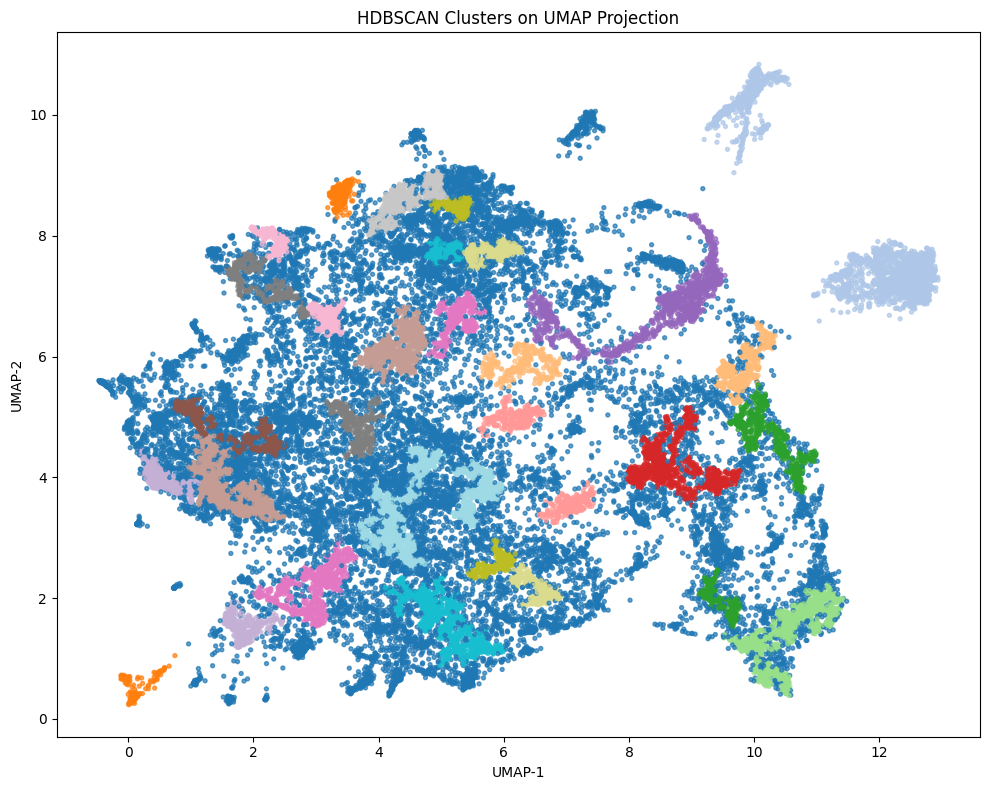

In [8]:
# Scatter plot of clusters in UMAP space

plt.figure(figsize=(10,8))
scatter = plt.scatter(
    df["umap_x"],
    df["umap_y"],
    c=df["cluster_id"],
    cmap="tab20",
    s=8,
    alpha=0.7
)
plt.title("HDBSCAN Clusters on UMAP Projection")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
plt.show()


In [ ]:
# Show top queries per cluster (themes)
cluster_summary = (
    df.groupby(["cluster_id", "query_id"])
      .size()
      .reset_index(name="count")
      .sort_values(["cluster_id", "count"], ascending=[True, False])
)

cluster_summary.head(20)


In [ ]:
# Summary: cluster sizes and % of noise
cluster_counts = df["cluster_id"].value_counts()
noise_pct = 100 * cluster_counts.get(-1, 0) / len(df)

print("Cluster count summary:")
print(cluster_counts.head(10))
print(f"\nNoise articles: {noise_pct:.1f}%")


In [ ]:
# Show one representative abstract per cluster (closest to centroid)

cluster_reps = []

for cid in sorted(df["cluster_id"].unique()):
    if cid == -1:
        continue

    idxs = df[df["cluster_id"] == cid].index
    if len(idxs) == 0:
        continue

    emb_sub = embeddings[idxs]
    centroid = emb_sub.mean(axis=0, keepdims=True)
    sims = cosine_similarity(emb_sub, centroid).flatten()
    rep_idx = idxs[sims.argmax()]

    cluster_reps.append(df.loc[rep_idx, ["cluster_id", "query_id", "title", "clean_abs"]])

pd.DataFrame(cluster_reps).head(10)


In [ ]:
# Query distribution per cluster
cluster_query_summary = (
    df[df["cluster_id"] != -1]
    .groupby(["cluster_id", "query_id"])
    .size()
    .reset_index(name="count")
    .sort_values(["cluster_id", "count"], ascending=[True, False])
)

cluster_query_summary.head(20)


In [ ]:
# Keyword extraction per cluster (very simple version)
from collections import Counter
import re

def get_keywords(texts, top_k=10):
    tokens = []
    for t in texts:
        ts = re.findall(r"[a-zA-Z]+", t.lower())
        tokens.extend(ts)
    return Counter(tokens).most_common(top_k)

cluster_keywords = {}

for cid in sorted(df["cluster_id"].unique()):
    cluster_texts = df[df["cluster_id"] == cid]["clean_abs"].tolist()
    top_words = get_keywords(cluster_texts, top_k=12)
    cluster_keywords[cid] = top_words

cluster_keywords
